In [555]:
import numpy as np
import os
import shutil
import pandas as pd
import sys
import gzip
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import stats

## Import Files

In [556]:
path = '/Users/nanatang/VAserversim/m/Researchers/SerenaT/fromjapan_fullruns/'
file = 'grand_PVS_report.csv'


In [557]:
reportfile = os.path.join(path,file)
report = pd.read_csv(reportfile)
report['research group'].unique()
report

,subjects,research group,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_114_S_2392y00_i909791,EMCI,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes
1,ADNI3_114_S_4404y00_i949873,EMCI,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes
2,ADNI3_128_S_4742y00_i1039209,EMCI,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes
3,ADNI3_027_S_4919y04_i1398602,EMCI,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes
4,ADNI3_067_S_2304y02_i1215232,EMCI,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes
...,...,...,...,...,...,...,...,...,...,...
1824,ADNI3_127_S_6241y00_i1003918,MCI,794.0,4617.0,0.003538,460.0,2125.0,0.001628,no,yes
1825,ADNI3_029_S_6579y00_i1236493,MCI,2167.0,10298.0,0.007470,1543.0,6268.0,0.004547,no,yes
1826,ADNI3_153_S_6755y00_i1181918,MCI,2699.0,10761.0,0.007018,1860.0,6752.0,0.004404,no,no
1827,ADNI3_036_S_7044y00_i1546901,MCI,1259.0,4897.0,0.003490,679.0,2093.0,0.001492,no,yes


## Data cleaning

In [558]:
# step 1: fix all MCI labels
report_clean = report.replace(to_replace=r'.*MC.*', value='MCI', regex=True)
report_clean

,subjects,research group,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_114_S_2392y00_i909791,MCI,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes
1,ADNI3_114_S_4404y00_i949873,MCI,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes
2,ADNI3_128_S_4742y00_i1039209,MCI,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes
3,ADNI3_027_S_4919y04_i1398602,MCI,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes
4,ADNI3_067_S_2304y02_i1215232,MCI,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes
...,...,...,...,...,...,...,...,...,...,...
1824,ADNI3_127_S_6241y00_i1003918,MCI,794.0,4617.0,0.003538,460.0,2125.0,0.001628,no,yes
1825,ADNI3_029_S_6579y00_i1236493,MCI,2167.0,10298.0,0.007470,1543.0,6268.0,0.004547,no,yes
1826,ADNI3_153_S_6755y00_i1181918,MCI,2699.0,10761.0,0.007018,1860.0,6752.0,0.004404,no,no
1827,ADNI3_036_S_7044y00_i1546901,MCI,1259.0,4897.0,0.003490,679.0,2093.0,0.001492,no,yes


In [559]:
# step 2: other cleaning:
# anything that doesn't have WMH mask

nowmh = report_clean[report_clean['WMH mask'] == 'no'].index
report_clean.drop(nowmh,inplace=True)
report_clean

# group by disease stage
grouped = report_clean.groupby(['research group'])
ad = grouped.get_group('AD')
mci = grouped.get_group('MCI')
cn = grouped.get_group('CN')

# remove outliers in each group 3 std deviations on both sides)
cnoutlier = cn[(np.abs(stats.zscore(cn['pvscount'])) > 3) 
               | (np.abs(stats.zscore(cn['pvsvol'])) > 3) 
               | (np.abs(stats.zscore(cn['icv norm'])) > 3)
               | (np.abs(stats.zscore(cn['pvscountwm'])) > 3)
               | (np.abs(stats.zscore(cn['pvsvolwm'])) > 3)
               | (np.abs(stats.zscore(cn['icv norm wm'])) > 3)].index
cn.drop(cnoutlier,inplace=True)

mcioutlier = mci[(np.abs(stats.zscore(mci['pvscount'])) > 3) 
               | (np.abs(stats.zscore(mci['pvsvol'])) > 3) 
               | (np.abs(stats.zscore(mci['icv norm'])) > 3)
               | (np.abs(stats.zscore(mci['pvscountwm'])) > 3)
               | (np.abs(stats.zscore(mci['pvsvolwm'])) > 3)
               | (np.abs(stats.zscore(mci['icv norm wm'])) > 3)].index
mci.drop(mcioutlier,inplace=True)

adoutlier = ad[(np.abs(stats.zscore(ad['pvscount'])) > 3) 
               | (np.abs(stats.zscore(ad['pvsvol'])) > 3) 
               | (np.abs(stats.zscore(ad['icv norm'])) > 3)
               | (np.abs(stats.zscore(ad['pvscountwm'])) > 3)
               | (np.abs(stats.zscore(ad['pvsvolwm'])) > 3)
               | (np.abs(stats.zscore(ad['icv norm wm'])) > 3)].index
ad.drop(adoutlier,inplace=True)


/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_1282/1844847644.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cn.drop(cnoutlier,inplace=True)
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_1282/1844847644.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mci.drop(mcioutlier,inplace=True)
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_1282/1844847644.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

## Extract Stats

In [576]:
# step 3: extract global stats in each group (mean, std)
## this is done before the transform

col = ['CN', 'MCI', 'AD']
index = ['# of subjects','mean PVS count', 'std PVS count', 'mean PVS volume', 'std PVS volume', 'mean PVS volume normed', 'std PVS volume normed']

subjcounts = [str(cn.count()[0]),str(mci.count()[0]),str(ad.count()[0])]

mean_PVS_count = [cn['pvscount'].mean(), mci['pvscount'].mean(), ad['pvscount'].mean()]
std_PVS_count = [cn['pvscount'].std(), mci['pvscount'].std(), ad['pvscount'].std()]

mean_PVS_vol = [cn['pvsvol'].mean(), mci['pvsvol'].mean(), ad['pvsvol'].mean()]
std_PVS_vol = [cn['pvsvol'].std(), mci['pvsvol'].std(), ad['pvsvol'].std()]

mean_PVS_icvnorm = [cn['icv norm'].mean(), mci['icv norm'].mean(), ad['icv norm'].mean()]
std_PVS_icvnorm = [cn['icv norm'].std(), mci['icv norm'].std(), ad['icv norm'].std()]

statsall = pd.DataFrame([subjcounts,mean_PVS_count,std_PVS_count,mean_PVS_vol,std_PVS_vol,mean_PVS_icvnorm,std_PVS_icvnorm],index=index,columns=col)
statsall = statsall.style.set_caption('Stats PVS All')

mean_PVS_countwm = [cn['pvscountwm'].mean(), mci['pvscountwm'].mean(), ad['pvscountwm'].mean()]
std_PVS_countwm = [cn['pvscountwm'].std(), mci['pvscountwm'].std(), ad['pvscountwm'].std()]

mean_PVS_volwm = [cn['pvsvolwm'].mean(), mci['pvsvolwm'].mean(), ad['pvsvolwm'].mean()]
std_PVS_volwm = [cn['pvsvolwm'].std(), mci['pvsvolwm'].std(), ad['pvsvolwm'].std()]

mean_PVS_icvnormwm = [cn['icv norm wm'].mean(), mci['icv norm wm'].mean(), ad['icv norm wm'].mean()]
std_PVS_icvnormwm = [cn['icv norm wm'].std(), mci['icv norm wm'].std(), ad['icv norm wm'].std()]

statswm = pd.DataFrame([subjcounts,mean_PVS_countwm,std_PVS_countwm,mean_PVS_volwm,std_PVS_volwm,mean_PVS_icvnormwm,std_PVS_icvnormwm],index=index,columns=col)
statswm = statswm.style.set_caption('Stats PVS WM')

statswm

,CN,MCI,AD
# of subjects,716,792,98
mean PVS count,968.812849,1028.005051,1254.204082
std PVS count,615.662662,715.928891,939.405679
mean PVS volume,3258.716481,3573.422979,4197.826531
std PVS volume,2130.320859,2469.316015,3021.891242
mean PVS volume normed,0.002235,0.002429,0.002937
std PVS volume normed,0.001426,0.001677,0.002121


In [595]:
# step 3.5: same number subject correction

# # same number
# cn_num = cn[0:100]
# mci_num = mci[0:100]
# ad_num = ad

# # else keep the same
cn_num = cn
mci_num = mci
ad_num = ad

In [596]:
# step 4: since the data is not normally distributed (right skewed), we need to log transform it

# playing around with choices: pvscount	pvsvol icv norm	pvscountwm pvsvolwm	icv norm wm

# # transform for most skewed
# cn_txfm = np.log(cn_num['icv norm wm'])
# mci_txfm = np.log(mci_num['icv norm wm'])
# ad_txfm = np.log(ad_num['icv norm wm'])

# # transform for medium skewed
# cn_txfm = np.sqrt(cn_num['icv norm wm'])
# mci_txfm = np.sqrt(mci_num['icv norm wm'])
# ad_txfm = np.sqrt(ad_num['icv norm wm'])

# # no transform
cn_txfm = cn_num['icv norm wm']
mci_txfm = mci_num['icv norm wm']
ad_txfm = ad_num['icv norm wm']

# step 2.6: check that the tranform actually makes it normal - shapiro-wilks test?
## seems like I can't actually get it to be normal

print(stats.shapiro(cn_txfm))
print(stats.shapiro(mci_txfm))
print(stats.shapiro(ad_txfm))

ShapiroResult(statistic=0.9284610152244568, pvalue=5.610910437964077e-18)
ShapiroResult(statistic=0.9333770871162415, pvalue=2.6309170078060527e-18)
ShapiroResult(statistic=0.9341346025466919, pvalue=0.00010153340554097667)


In [597]:
# step 3: Stats (X^2, ANOVA, Ttest, Kruskal-Wallis, Mann-Whitney U )

# ANOVA?

fvalue, apvalue = stats.f_oneway(cn_txfm, mci_txfm, ad_txfm)
print('ANOVA: ' + str(fvalue) + ', ' + str(apvalue))

#ttest?
tvalue, tpvalue = stats.ttest_ind(cn_txfm,ad_txfm)
print('T-test: ' + str(tvalue) + ', ' + str(tpvalue))

#Kruskal?
kvalue, kpvalue = stats.kruskal(cn_txfm, mci_txfm, ad_txfm)
print('Kruskal Wallis: ' + str(kvalue) + ', ' + str(kpvalue))

#MannWhitney?
mvalue, mpvalue = stats.mannwhitneyu(cn_txfm,ad_txfm)
print('Mann-Whitney U: ' + str(mvalue) + ', ' + str(mpvalue))

# bootstrap?



ANOVA: 9.235232713009971, 0.00010283017336501888
T-test: -4.275554030704678, 2.1331949985259826e-05
Kruskal Wallis: 7.379491304455769, 0.02497835442318359
Mann-Whitney U: 29522.0, 0.010846134287939424


## Plots

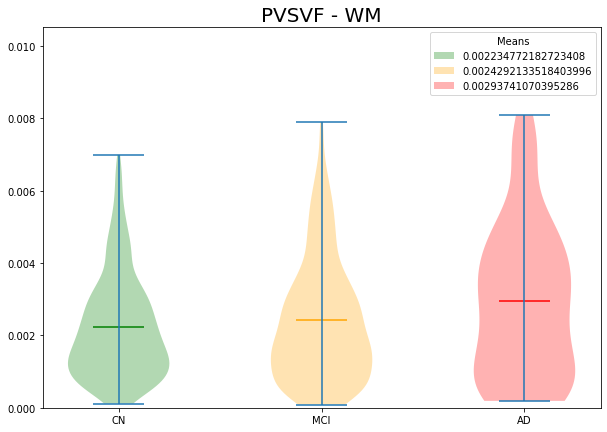

In [622]:
# step 4: plot stuff

#try: https://stackoverflow.com/questions/67376683/can-you-have-a-box-plot-overlap-a-half-violin-plot-on-a-raincloud-plot-using-pyt
#try: https://github.com/pog87/PtitPrince


## combine these different collections into a list
data_to_plot = [cn_txfm, mci_txfm, ad_txfm]

# Create a figure instance
fig = plt.figure(figsize=(10,7))

# Create the boxplot
violin = plt.violinplot(data_to_plot,positions=[1,2,3],showmeans=True,showextrema=True)

# Set the color of the violin patches
colors = ['Green', 'Orange', 'Red']
for pc, color in zip(violin['bodies'], colors):
    pc.set_facecolor(color)
violin['cmeans'].set_colors(colors)
plt.xticks([1, 2, 3], labels=['CN', 'MCI', 'AD'])
plt.legend([np.mean(cn_txfm), np.mean(mci_txfm), np.mean(ad_txfm)],title='Means')
plt.ylim(0,ad_txfm.max()*1.3)
plt.title('PVSVF - WM',fontsize=20)

# y, h, col = max(map(max, data_to_plot)) + 2, 2, 'k'
# plt.text(,y+h, "*", ha='center', va='bottom', color=col)

plt.show()

In [ ]:
# stats comparison giant table
# need to compute: 
    # non transformed & transformed for: pvscount  pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm
    # shapiro-wilks test for: pvscount  pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm
    # ANOVA, ttest, kruskal wallis, mann whitney u for: cn vs ad, cn vs mci, mci vs ad for each condition above
    # means and std


    
    

In [ ]:
# step n: regional stats (need to come up with a pipeline for this, not straight forward)
# should get: HP, GM / BG, CSO